<a href="https://colab.research.google.com/github/a-v-kolos/Allen_dataset_neuromatch_2025/blob/sebastien_bullich/DriftFamiliar_230725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# ---------------------------------------------------------------
# Mount Google Drive and define output path
# ---------------------------------------------------------------
drive.mount("/content/drive", force_remount=True)
OUTPUT_DIR = "/content/drive/MyDrive/pca_drift_results_onlychanged"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------------------------------------
# Parameters
# ---------------------------------------------------------------
SESSION_COL   = "ophys_session_id"
EARLY_FRAC    = 0.25
LATE_FRAC     = 0.25
MAX_PC        = 20
INCLUDED_IMAGES = ["im000", "im106", "im075", "im073", "im045", "im054", "im031", "im035", "omitted"]

# Set plot style
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0, palette="colorblind")

# Results container
rows = []

# Extracting data
file_path = "/content/drive/MyDrive/allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(file_path)
sst_data_changedonly = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)&(data.exposure_level == "familiar")&(data.session_type == "OPHYS_3_images_B")&(data.targeted_structure == "VISp")]
print(sst_data_changedonly.shape)

# After creating sst_data_changedonly
BAD_MOUSE   = 476970
DROP_SESSION = 994731371   # the one you want to remove
KEEP_SESSION = 994199725   # just for clarity, not used

sst_data_changedonly = sst_data_changedonly[~((sst_data_changedonly["mouse_id"] == BAD_MOUSE) &
                          (sst_data_changedonly[SESSION_COL] == DROP_SESSION))].copy()

# Optional sanity check
print(sst_data_changedonly.loc[sst_data_changedonly["mouse_id"] == BAD_MOUSE, SESSION_COL].unique())
print(sst_data_changedonly.shape)

# Loop over all sessions and images
for sess in sst_data_changedonly[SESSION_COL].unique():
    df_sess = sst_data_changedonly[sst_data_changedonly[SESSION_COL] == sess].copy()

    # Create a subfolder for this mouse/session
    #mouse_plot_dir = os.path.join(OUTPUT_DIR, "plots", f"session_{sess}")
    #os.makedirs(mouse_plot_dir, exist_ok=True)

    # Get animal ID for this session (assumes 1 per session)
    mouse_id = df_sess["mouse_id"].iloc[0] if "mouse_id" in df_sess.columns else "unknown"

    # Create subfolder using both mouse and session
    mouse_plot_dir = os.path.join(OUTPUT_DIR, "plots", f"mouse_{mouse_id}_session_{sess}")
    os.makedirs(mouse_plot_dir, exist_ok=True)

    for img in df_sess["image_name"].unique():
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_sess[df_sess["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        # Δ response and block labels
        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

     # Population matrix
        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                        columns="stimulus_presentations_id",
                        values="delta_response",
                        aggfunc="mean")
            .dropna(axis=0, how="all")
            .dropna(axis=1, how="all")
        )

        # Now remove remaining rows/columns with any NaNs (safer than fillna(0.0))
        M_df = M_df.dropna(axis=0, how="any").dropna(axis=1, how="any")

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trials = M.shape[1]
        cells = M.shape[0]

        # Block masks
        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"

        if not is_early.any() or not is_late.any():
            continue

        # Drift calculation
        v_e = np.mean(M[:, is_early], axis=1)
        v_l = np.mean(M[:, is_late], axis=1)
        if np.isnan(v_e).all() or np.isnan(v_l).all():
            continue

        drift = v_l - v_e
        mag = np.linalg.norm(np.nan_to_num(drift))
        denom = np.linalg.norm(np.nan_to_num(v_e)) * np.linalg.norm(np.nan_to_num(v_l))
        cosang = np.clip((np.nan_to_num(v_e) @ np.nan_to_num(v_l)) / denom if denom else 1, -1, 1)
        angle = np.degrees(np.arccos(cosang))

        rows.append({
            "ophys_session_id": sess,
            "image_name": img,
            "drift_magnitude": mag,
            "drift_angle": angle
        })

        # PCA and plot
        n_comp = min(MAX_PC, trials, cells)
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        if n_comp >= 2:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.scatter(scores[is_early, 0], scores[is_early, 1],
                       label="early", alpha=0.7, s=40, edgecolor='k')
            ax.scatter(scores[is_late, 0], scores[is_late, 1],
                       label="late", alpha=0.7, s=40, edgecolor='k', marker='^')

            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)
            ax.scatter(*ec, s=100, color='red', marker='o', edgecolor='k')
            ax.scatter(*lc, s=100, color='blue', marker='^', edgecolor='k')
            ax.annotate("", xy=lc, xytext=ec,
                        arrowprops=dict(arrowstyle="->", lw=2, color="gray"))

            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_title(f"Session {sess} — Image {img}")
            ax.legend()
            fig.tight_layout()
            fig.savefig(os.path.join(mouse_plot_dir, f"image_{img}.png"))
            plt.close(fig)

# Save drift table
df_out = pd.DataFrame(rows)
df_out.to_csv(os.path.join(OUTPUT_DIR, "drift_metrics_filtered.csv"), index=False)

# Confirm results
print("✅ Done!")
print(f"Saved {len(df_out)} drift metric rows for filtered images")
print("Results saved to:", OUTPUT_DIR)


Mounted at /content/drive
(25380, 31)
[]
(25380, 31)
✅ Done!
Saved 64 drift metric rows for filtered images
Results saved to: /content/drive/MyDrive/pca_drift_results_onlychanged


In [44]:
# Extracting data

file_path = "/content/drive/MyDrive/allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(file_path)
sst_data_changedonly = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == "true")&(data.exposure_level == "familiar")&(data.session_type == "OPHYS_3_images_B")&(data.targeted_structure == "VISp")]
print(sst_data_changedonly.shape)

(0, 31)


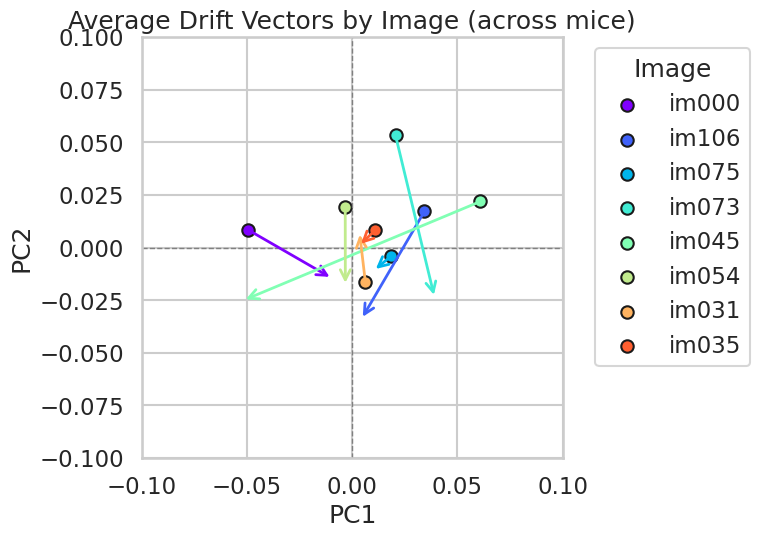

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from collections import defaultdict

# Define color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(INCLUDED_IMAGES)))
image_color_map = dict(zip(INCLUDED_IMAGES, colors))

# Containers for early and late centroids per image per mouse
centroid_data = defaultdict(list)  # key = image_name, value = list of (early, late) centroid tuples

for mouse in sst_data_changedonly["mouse_id"].unique():
    df_mouse = sst_data_changedonly[sst_data_changedonly["mouse_id"] == mouse]

    for img in df_mouse["image_name"].unique():
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_mouse[df_mouse["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                         columns="stimulus_presentations_id",
                         values="delta_response",
                         aggfunc="mean")
            .dropna(axis=0, how="any")
            .dropna(axis=1, how="any")
        )

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"

        if not is_early.any() or not is_late.any():
            continue

        n_comp = min(MAX_PC, M.shape[0], M.shape[1])
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        if n_comp >= 2:
            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)
            centroid_data[img].append((ec, lc))

# Compute average centroids and plot arrows
plt.figure(figsize=(8, 8))
ax = plt.gca()

for img_idx, img in enumerate(INCLUDED_IMAGES):
    if img not in centroid_data:
        continue

    all_ec = np.array([pair[0] for pair in centroid_data[img]])
    all_lc = np.array([pair[1] for pair in centroid_data[img]])

    mean_ec = all_ec.mean(axis=0)
    mean_lc = all_lc.mean(axis=0)

    # Arrow
    ax.annotate("",
                xy=mean_lc, xytext=mean_ec,
                arrowprops=dict(arrowstyle="->", lw=2, color=image_color_map[img]))
    ax.scatter(*mean_ec, color=image_color_map[img], edgecolor='k', s=80, label=img)

# Axis formatting
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_title("Average Drift Vectors by Image (across mice)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_aspect("equal")
ax.legend(title="Image", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

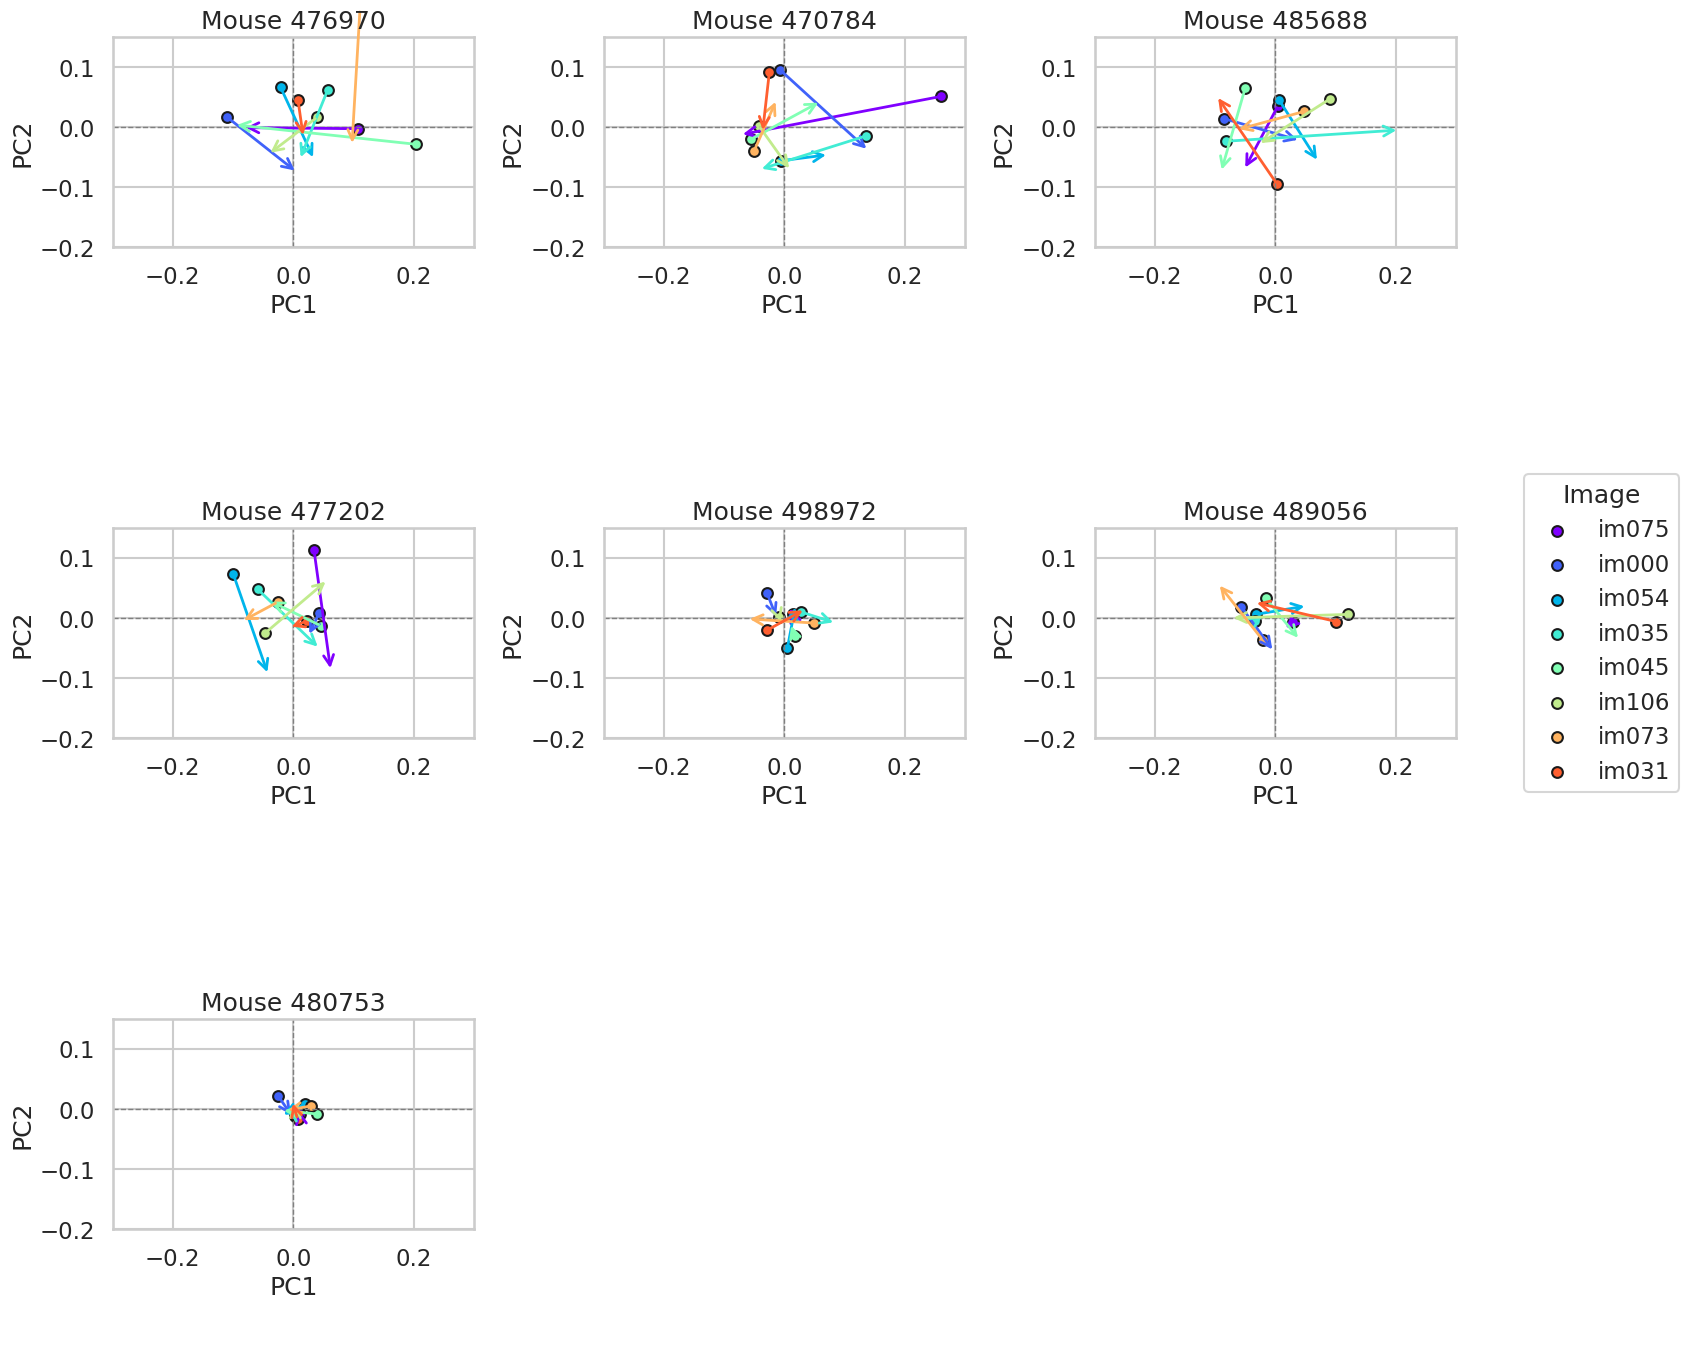

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap

# Prepare
mice = sst_data_changedonly["mouse_id"].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(INCLUDED_IMAGES)))
n_mice = len(mice)
ncols = 3
nrows = int(np.ceil(n_mice / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axs = axs.flatten()

for idx, mouse in enumerate(mice):
    ax = axs[idx]
    df_mouse = sst_data_changedonly[sst_data_changedonly["mouse_id"] == mouse]

    for img_idx, img in enumerate(df_mouse["image_name"].unique()):
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_mouse[df_mouse["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                         columns="stimulus_presentations_id",
                         values="delta_response",
                         aggfunc="mean")
            .dropna(axis=0, how="any")
            .dropna(axis=1, how="any")
        )

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"

        if not is_early.any() or not is_late.any():
            continue

        n_comp = min(MAX_PC, M.shape[0], M.shape[1])
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        if n_comp >= 2:
            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)

            ax.annotate("",
                        xy=lc, xytext=ec,
                        arrowprops=dict(arrowstyle="->", lw=2, color=colors[img_idx]))
            ax.scatter(*ec, color=colors[img_idx], edgecolor='k', s=60, label=img)

    ax.set_title(f"Mouse {mouse}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_aspect("equal")
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.2, 0.15)

# Hide any unused subplots
for i in range(n_mice, len(axs)):
    axs[i].axis("off")

# Global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Image", bbox_to_anchor=(1.02, 0.5), loc="center left")

plt.tight_layout()
plt.show()


Mounted at /content/drive
Filtered data shape: (25380, 31)


/tmp/ipython-input-11-865887925.py:183: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_images))
/tmp/ipython-input-11-865887925.py:183: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_images))
/tmp/ipython-input-11-865887925.py:183: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_images))
/tmp/ipython-input-11-865887925.py:183: MatplotlibDeprecationWar

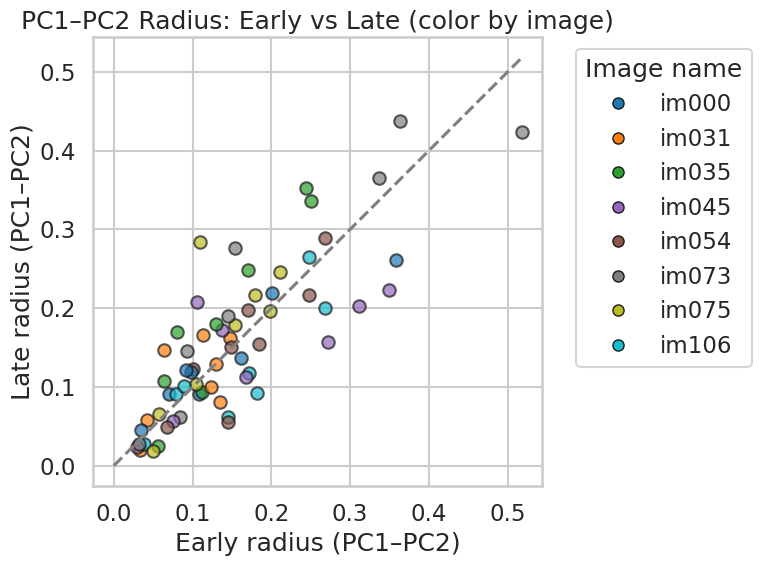

/tmp/ipython-input-11-865887925.py:384: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(unique_images))


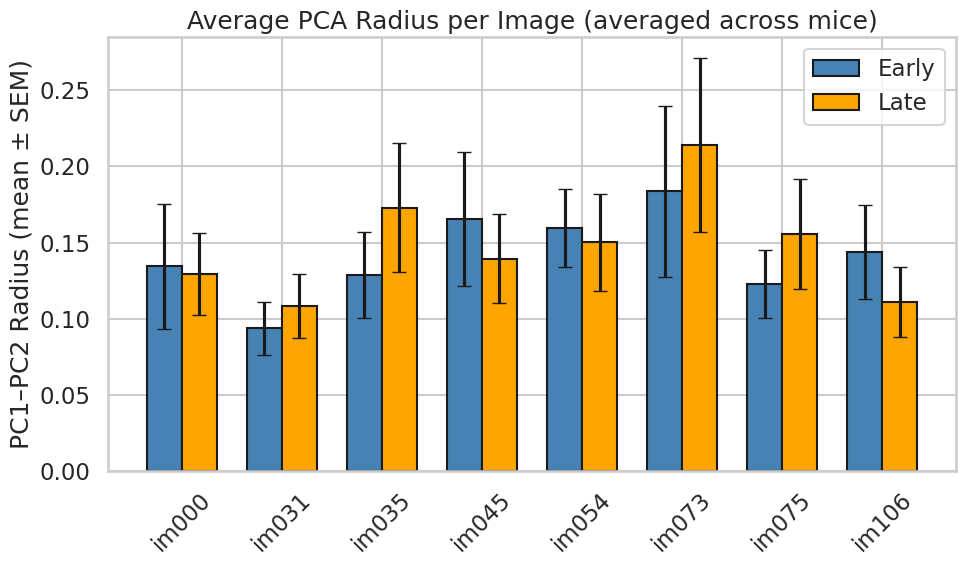

✅ Done!
Saved 64 drift metric rows for filtered images
Results saved to: /content/drive/MyDrive/pca_drift_results_Euclidiandistance


In [11]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab import drive

# ---------------------------------------------------------------
# Mount Google Drive and define output path
# ---------------------------------------------------------------
drive.mount("/content/drive", force_remount=True)
OUTPUT_DIR = "/content/drive/MyDrive/pca_drift_results_Euclidiandistance"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------------------------------------
# Parameters
# ---------------------------------------------------------------
SESSION_COL   = "ophys_session_id"
EARLY_FRAC    = 0.25
LATE_FRAC     = 0.25
MAX_PC        = 20
INCLUDED_IMAGES = ["im000", "im106", "im075", "im073", "im045", "im054", "im031", "im035"]

# Set plot style
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0, palette="colorblind")

# Results container
rows = []

# Extracting data
file_path = "/content/drive/MyDrive/allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(file_path)
sst_data_2 = data[
    (data.cre_line           == "Sst-IRES-Cre") &
    (data.omitted            == False) &
    (data.exposure_level     == "familiar") &
    (data.targeted_structure == "VISp") &
    (data.session_type       == "OPHYS_3_images_B")
]
print("Filtered data shape:", sst_data_changedonly.shape)

# Loop over all sessions
for sess in sst_data_changedonly[SESSION_COL].unique():
    df_sess = sst_data_changedonly[sst_data_changedonly[SESSION_COL] == sess].copy()

    mouse_id = df_sess["mouse_id"].iloc[0] if "mouse_id" in df_sess.columns else "unknown"
    mouse_plot_dir = os.path.join(OUTPUT_DIR, "plots", f"mouse_{mouse_id}_session_{sess}")
    os.makedirs(mouse_plot_dir, exist_ok=True)

    session_M_df_list = []
    session_scores_list = []
    session_trial_info_list = []

    for img in df_sess["image_name"].unique():
        if img not in INCLUDED_IMAGES:
            continue

        df_img = df_sess[df_sess["image_name"] == img].copy()
        if len(df_img) < 2:
            continue

        df_img["delta_response"] = df_img["mean_response"] - df_img["baseline_response"]
        df_img = df_img.sort_values("stimulus_presentations_id").reset_index(drop=True)
        N = len(df_img)
        early_cut  = max(1, int(np.floor(EARLY_FRAC * N)))
        late_start = N - max(1, int(np.ceil(LATE_FRAC * N)))
        df_img["block"] = np.where(
            df_img.index < early_cut, "early",
            np.where(df_img.index >= late_start, "late", "middle")
        )

        M_df = (
            df_img
            .pivot_table(index="cell_specimen_id",
                         columns="stimulus_presentations_id",
                         values="delta_response",
                         aggfunc="mean")
            .dropna(axis=0, how="all")
            .dropna(axis=1, how="all")
        ).dropna(axis=0, how="any").dropna(axis=1, how="any")

        M = M_df.to_numpy()
        if M.shape[0] < 2 or M.shape[1] < 2:
            continue

        trial_blocks = (
            df_img[["stimulus_presentations_id", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)["block"]
            .fillna("unknown")
            .to_numpy()
        )
        is_early = trial_blocks == "early"
        is_late  = trial_blocks == "late"
        if not is_early.any() or not is_late.any():
            continue

        v_e = np.mean(M[:, is_early], axis=1)
        v_l = np.mean(M[:, is_late], axis=1)
        if np.isnan(v_e).all() or np.isnan(v_l).all():
            continue

        drift = v_l - v_e
        mag = np.linalg.norm(np.nan_to_num(drift))
        denom = np.linalg.norm(np.nan_to_num(v_e)) * np.linalg.norm(np.nan_to_num(v_l))
        cosang = np.clip((np.nan_to_num(v_e) @ np.nan_to_num(v_l)) / denom if denom else 1, -1, 1)
        angle = np.degrees(np.arccos(cosang))

        # PCA
        n_comp = min(MAX_PC, M.shape[1], M.shape[0])
        pca = PCA(n_components=n_comp).fit(M.T)
        scores = pca.transform(M.T)

        # Radius in PC1–PC2 space
        r2 = np.sqrt(scores[:, 0]**2 + scores[:, 1]**2)
        r2_early = r2[is_early]
        r2_late  = r2[is_late]
        rad_early_mean = np.nanmean(r2_early) if r2_early.size else np.nan
        rad_late_mean  = np.nanmean(r2_late)  if r2_late.size  else np.nan
        rad_early_median = np.nanmedian(r2_early) if r2_early.size else np.nan
        rad_late_median  = np.nanmedian(r2_late)  if r2_late.size  else np.nan

        # Save results
        rows.append({
            "mouse_id": mouse_id,
            "ophys_session_id": sess,
            "image_name": img,
            "drift_magnitude": mag,
            "drift_angle": angle,
            "pc2_radius_early_mean": rad_early_mean,
            "pc2_radius_late_mean": rad_late_mean,
            "pc2_radius_early_median": rad_early_median,
            "pc2_radius_late_median": rad_late_median,
            "n_early_trials": int(is_early.sum()),
            "n_late_trials": int(is_late.sum())
        })

        # Save for multi-image PCA plot
        session_M_df_list.append(M_df)
        session_scores_list.append(scores)
        trial_info_df = (
            df_img[["stimulus_presentations_id", "image_name", "block"]]
            .drop_duplicates("stimulus_presentations_id")
            .set_index("stimulus_presentations_id")
            .reindex(M_df.columns)
        )
        session_trial_info_list.append(trial_info_df)

        # Per-image PCA plot
        if n_comp >= 2:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.scatter(scores[is_early, 0], scores[is_early, 1],
                       label="early", alpha=0.7, s=40, edgecolor='k')
            ax.scatter(scores[is_late, 0], scores[is_late, 1],
                       label="late", alpha=0.7, s=40, edgecolor='k', marker='^')

            ec = scores[is_early, :2].mean(axis=0)
            lc = scores[is_late, :2].mean(axis=0)
            ax.scatter(*ec, s=100, color='red', marker='o', edgecolor='k')
            ax.scatter(*lc, s=100, color='blue', marker='^', edgecolor='k')
            ax.annotate("", xy=lc, xytext=ec,
                        arrowprops=dict(arrowstyle="->", lw=2, color="gray"))

            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_title(f"Session {sess} — Image {img}")
            ax.legend()
            fig.tight_layout()
            fig.savefig(os.path.join(mouse_plot_dir, f"image_{img}.png"))
            plt.close(fig)

    # Multi-image PCA plot
    if session_scores_list and session_trial_info_list:
        all_scores = np.concatenate(session_scores_list, axis=0)
        all_trial_info = pd.concat(session_trial_info_list)
        trial_image_map = all_trial_info["image_name"].fillna("unknown").to_numpy()
        trial_block_map = all_trial_info["block"].fillna("unknown").to_numpy()

        unique_images = np.unique(trial_image_map)
        cmap = cm.get_cmap("tab10", len(unique_images))
        image_to_color = {img: cmap(i) for i, img in enumerate(unique_images)}

        fig, ax = plt.subplots(figsize=(8, 6))
        for img in unique_images:
            is_img = (trial_image_map == img)
            is_img_early = is_img & (trial_block_map == "early")
            is_img_late  = is_img & (trial_block_map == "late")

            if np.any(is_img_early):
                early_centroid = all_scores[is_img_early, :2].mean(axis=0)
                ax.scatter(*early_centroid, marker='o', s=150,
                           edgecolor='k', color=image_to_color[img], label=f"{img} early")
            if np.any(is_img_late):
                late_centroid = all_scores[is_img_late, :2].mean(axis=0)
                ax.scatter(*late_centroid, marker='^', s=150,
                           edgecolor='k', color=image_to_color[img], label=f"{img} late")
            if np.any(is_img_early) and np.any(is_img_late):
                ax.annotate("",
                    xy=late_centroid, xytext=early_centroid,
                    arrowprops=dict(arrowstyle="->", lw=2, color=image_to_color[img])
                )

        ax.set_xlabel("PC1 score")
        ax.set_ylabel("PC2 score")
        ax.set_title(f"PCA: Early→Late centroids per image\nMouse {mouse_id} — Session {sess}")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
        sns.despine(trim=True)
        fig.tight_layout()
        fig.savefig(os.path.join(mouse_plot_dir, "multi_image_centroids.png"))
        plt.close(fig)

# Save drift table
df_out = pd.DataFrame(rows)
df_out.to_csv(os.path.join(OUTPUT_DIR, "drift_metrics_filtered.csv"), index=False)

import matplotlib.cm as cm
import matplotlib.colors as mcolors

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Final summary plot: early vs. late radius, color-coded by image
plt.figure(figsize=(6, 6))

# Get unique image names
image_names = sorted(df_out["image_name"].unique())
cmap = cm.get_cmap("tab10", len(image_names))
image_color_map = {img: cmap(i) for i, img in enumerate(image_names)}

# Plot each point with color by image name
for _, row in df_out.iterrows():
    x = row["pc2_radius_early_mean"]
    y = row["pc2_radius_late_mean"]
    img = row["image_name"]
    plt.scatter(x, y, color=image_color_map[img], edgecolor='k', alpha=0.7)

# Diagonal reference line
lim = max(df_out[["pc2_radius_early_mean", "pc2_radius_late_mean"]].max())
plt.plot([0, lim], [0, lim], ls='--', color='gray')

# Aesthetics
plt.xlabel("Early radius (PC1–PC2)")
plt.ylabel("Late radius (PC1–PC2)")
plt.title("PC1–PC2 Radius: Early vs Late (color by image)")
plt.gca().set_aspect('equal')
plt.tight_layout()

# Add legend for image names
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=str(img),
               markerfacecolor=image_color_map[img], markeredgecolor='k', markersize=8)
    for img in image_names
]
plt.legend(handles=handles, title="Image name", bbox_to_anchor=(1.05, 1), loc="upper left")

# Save and show
plt.savefig(os.path.join(OUTPUT_DIR, "radius_scatter_colored_by_image.png"))
plt.show()

from scipy.stats import sem

from scipy.stats import sem

import seaborn as sns

import seaborn as sns
from scipy.stats import wilcoxon

# ---------------------------------------------------------------
# Step 1: Per-mouse PC radius for each image (already computed)
# ---------------------------------------------------------------
mouse_image_df = df_out.groupby(["mouse_id", "image_name"]).agg({
    "pc2_radius_early_mean": "mean",
    "pc2_radius_late_mean": "mean"
}).reset_index()

# ---------------------------------------------------------------
# Step 2: Reshape to long format
# ---------------------------------------------------------------
mouse_image_long = pd.melt(
    mouse_image_df,
    id_vars=["mouse_id", "image_name"],
    value_vars=["pc2_radius_early_mean", "pc2_radius_late_mean"],
    var_name="block",
    value_name="pc2_radius"
)
mouse_image_long["block"] = mouse_image_long["block"].map({
    "pc2_radius_early_mean": "early",
    "pc2_radius_late_mean": "late"
})

# ---------------------------------------------------------------
# Step 3: Run paired Wilcoxon tests per image
# ---------------------------------------------------------------
pvals = {}
for img in mouse_image_df["image_name"].unique():
    df_img = mouse_image_df[mouse_image_df["image_name"] == img]
    if len(df_img) > 1:  # Need at least 2 mice
        stat, p = wilcoxon(df_img["pc2_radius_early_mean"], df_img["pc2_radius_late_mean"])
        pvals[img] = p
    else:
        pvals[img] = np.nan

import seaborn as sns
from scipy.stats import wilcoxon
import matplotlib.cm as cm

# ---------------------------------------------------------------
# Step 1: Per-mouse radius per image
# ---------------------------------------------------------------
mouse_image_df = df_out.groupby(["mouse_id", "image_name"]).agg({
    "pc2_radius_early_mean": "mean",
    "pc2_radius_late_mean": "mean"
}).reset_index()

# ---------------------------------------------------------------
# Step 2: Long format
# ---------------------------------------------------------------
mouse_image_long = pd.melt(
    mouse_image_df,
    id_vars=["mouse_id", "image_name"],
    value_vars=["pc2_radius_early_mean", "pc2_radius_late_mean"],
    var_name="block",
    value_name="pc2_radius"
)
mouse_image_long["block"] = mouse_image_long["block"].map({
    "pc2_radius_early_mean": "early",
    "pc2_radius_late_mean": "late"
})

# ---------------------------------------------------------------
# Step 3: Wilcoxon test per image
# ---------------------------------------------------------------
pvals = {}
for img in mouse_image_df["image_name"].unique():
    df_img = mouse_image_df[mouse_image_df["image_name"] == img]
    if len(df_img) > 1:
        stat, p = wilcoxon(df_img["pc2_radius_early_mean"], df_img["pc2_radius_late_mean"])
        pvals[img] = p
    else:
        pvals[img] = np.nan

import seaborn as sns
from scipy.stats import wilcoxon
import matplotlib.cm as cm

import seaborn as sns
from scipy.stats import wilcoxon
import matplotlib.cm as cm

# Step 1: Prepare data
mouse_image_df = df_out.groupby(["mouse_id", "image_name"]).agg({
    "pc2_radius_early_mean": "mean",
    "pc2_radius_late_mean": "mean"
}).reset_index()

mouse_image_long = pd.melt(
    mouse_image_df,
    id_vars=["mouse_id", "image_name"],
    value_vars=["pc2_radius_early_mean", "pc2_radius_late_mean"],
    var_name="block",
    value_name="pc2_radius"
)
mouse_image_long["block"] = mouse_image_long["block"].map({
    "pc2_radius_early_mean": "early",
    "pc2_radius_late_mean": "late"
})

# Step 2: Statistical tests (paired per image)
pvals = {}
for img in mouse_image_df["image_name"].unique():
    df_img = mouse_image_df[mouse_image_df["image_name"] == img]
    if len(df_img) > 1:
        stat, p = wilcoxon(df_img["pc2_radius_early_mean"], df_img["pc2_radius_late_mean"])
        pvals[img] = p
    else:
        pvals[img] = np.nan

# Step 3: Color palette per image
unique_images = sorted(mouse_image_df["image_name"].unique())
cmap = cm.get_cmap("tab10", len(unique_images))
image_color_map = {img: cmap(i) for i, img in enumerate(unique_images)}

# Create a color palette for each block (early and late get same base color per image)
# We hack this using tuples like (image_name, block) to index
block_colors = {}
for img in unique_images:
    color = image_color_map[img]
    block_colors[(img, "early")] = color
    block_colors[(img, "late")]  = color

# Create a categorical column combining image and block for coloring
mouse_image_long["group"] = list(zip(mouse_image_long["image_name"], mouse_image_long["block"]))

import seaborn as sns
from scipy.stats import wilcoxon

import seaborn as sns

from scipy.stats import sem

# ---------------------------------------------------------------
# Step 1: Average radius per mouse × image
# ---------------------------------------------------------------
mouse_image_df = df_out.groupby(["mouse_id", "image_name"]).agg({
    "pc2_radius_early_mean": "mean",
    "pc2_radius_late_mean": "mean"
}).reset_index()

# ---------------------------------------------------------------
# Step 2: Average across mice (per image)
# ---------------------------------------------------------------
image_summary_df = mouse_image_df.groupby("image_name").agg({
    "pc2_radius_early_mean": ["mean", sem],
    "pc2_radius_late_mean": ["mean", sem]
})
image_summary_df.columns = ["early_mean", "early_sem", "late_mean", "late_sem"]
image_summary_df = image_summary_df.reset_index()

# ---------------------------------------------------------------
# Step 3: Bar plot with error bars (mean ± SEM)
# ---------------------------------------------------------------
x = np.arange(len(image_summary_df["image_name"]))
bar_width = 0.35

plt.figure(figsize=(10, 6))

# Early bars
plt.bar(x - bar_width/2, image_summary_df["early_mean"], bar_width,
        yerr=image_summary_df["early_sem"], capsize=5, label="Early",
        color="steelblue", edgecolor='k')

# Late bars
plt.bar(x + bar_width/2, image_summary_df["late_mean"], bar_width,
        yerr=image_summary_df["late_sem"], capsize=5, label="Late",
        color="orange", edgecolor='k')

# Aesthetics
plt.xticks(x, image_summary_df["image_name"], rotation=45)
plt.ylabel("PC1–PC2 Radius (mean ± SEM)")
plt.title("Average PCA Radius per Image (averaged across mice)")
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig(os.path.join(OUTPUT_DIR, "mean_radius_per_image_across_mice.png"))
plt.show()


# Confirm results
print("✅ Done!")
print(f"Saved {len(df_out)} drift metric rows for filtered images")
print("Results saved to:", OUTPUT_DIR)
